
# ATUS Evaluation (R1–R6): B1‑H vs B2‑H with Bootstrap CIs

**Purpose.** This notebook provides a clean, lightweight evaluation workflow for rungs **R1–R6**:
1) For each rung, compare **B1‑H** (routing only) vs **B2‑H** (routing + hazard) using **bootstrap CIs** on **population‑weighted NLL** and **Top‑1 accuracy** (per respondent).  
2) Separately, test whether **adding a covariate** (e.g., `sex`, `employment`, etc.) improves predictions (B1‑H or B2‑H — you choose).

**Key files assumed per rung directory** (under `atus_analysis/data/models/R{1-6}`):
- `test_case_metrics_b1h.parquet`  
- `test_case_metrics_b2h.parquet`  
(If only `test_case_metrics.parquet` is present, the loader will use it.)

**Outputs**
- Summary tables of mean metrics by rung & variant
- Bootstrap **95% CIs** for ΔNLL (A−B) and ΔTop1
- Forest plots for quick significance inspection
- Optional CSV exports of results


# Bootstrap comparison (paired PPS by survey weight)

Let **A** be the baseline and **B** the candidate.

## Procedure (per bootstrap draw)

1. **Align** respondents on `TUCASEID` present in both runs.

2. **Resample respondents with replacement** using **probability proportional to size (PPS)** where size = `weight_total` from run **A**.  
   If any weights are missing/nonpositive/NaN, fall back to **uniform** resampling.

3. For the sampled respondents, compute per-draw aggregates:

$$
\text{NLL}_A =
\frac{\sum_i \text{nll_weighted}_{A,i}}{\sum_i \text{weight_total}_{A,i}},
\qquad
\text{NLL}_B =
\frac{\sum_i \text{nll_weighted}_{B,i}}{\sum_i \text{weight_total}_{B,i}}
$$

$$
\text{Top1}_A =
\frac{\sum_i \text{top1_correct_weight}_{A,i}}{\sum_i \text{weight_total}_{A,i}},
\qquad
\text{Top1}_B =
\frac{\sum_i \text{top1_correct_weight}_{B,i}}{\sum_i \text{weight_total}_{B,i}}
$$

4. Record differences:

   - $\Delta \text{NLL} = \text{NLL}_A - \text{NLL}_B$ → **negative** ⇒ **B is better** (lower NLL).
   - $\Delta \text{Top1} = \text{Top1}_A - \text{Top1}_B$ → **positive** ⇒ **A is better** (higher accuracy).

## Reporting (after \(B\) draws)

- Mean $\Delta \text{NLL}$ with **95% CI** (2.5–97.5 percentiles).  
- Mean $\Delta \text{Top1}$ with **95% CI**.  
- Relative improvement (%):

$$
\text{Rel. improv} \;=\; -\,\frac{\mathbb{E}[\Delta \text{NLL}]}{\mathbb{E}[\text{NLL}_A]}\times 100
\quad (\text{when } \mathbb{E}[\text{NLL}_A]\neq 0)
$$

**Interpretation.** If the 95% CI for \(\Delta \text{NLL}\) is entirely **below 0**, then **B** has significantly lower NLL than **A** at the 5% level.


In [1]:

from __future__ import annotations

import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- Project roots (robust discovery) ---------
def _guess_models_dir() -> Path:
    # Try common relative layouts (this notebook expected under .../notebooks)
    here = Path.cwd().resolve()
    candidates = []
    # 1) ../../atus_analysis/data/models relative to notebooks/
    candidates.append(here / ".." / "atus_analysis" / "data" / "models")
    # 2) ../data/models if running from scripts/
    candidates.append(here / ".." / "data" / "models")
    # 3) Search up to 4 levels for 'atus_analysis/data/models'
    up = here
    for _ in range(4):
        candidates.append(up / "atus_analysis" / "data" / "models")
        up = up.parent
    # 4) Env var override
    env = os.environ.get("ATUS_MODELS_DIR")
    if env:
        candidates.insert(0, Path(env))

    for p in candidates:
        if p.exists() and p.is_dir():
            return p.resolve()
    raise FileNotFoundError("Could not locate 'atus_analysis/data/models'. "
                            "Set ATUS_MODELS_DIR environment variable to the models directory.")

MODELS_DIR = _guess_models_dir()
print("Models dir →", MODELS_DIR)

# Rungs to evaluate
RUNGS = [f"R{i}" for i in range(0, 12)]  # R1..R6
VARIANTS = ("b1h", "b2h")

# Bootstrap settings (can change B if you want tighter CIs)
B = 2000
SEED = 2025

# Export toggle
WRITE_CSV = True
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)
print("Output dir →", OUT_DIR.resolve())


Models dir → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models
Output dir → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs



## Load per‑respondent metrics (test set)

Each metrics parquet must contain at least:
- `TUCASEID`, `nll_weighted`, `top1_correct_weight`, `weight_total`, `transitions`

We also compute convenience columns:
- `nll = nll_weighted / weight_total`
- `top1_acc = top1_correct_weight / weight_total`


In [2]:

from typing import Optional, Dict

def _metrics_path(run_dir: Path, variant: str) -> Optional[Path]:
    # Preferred variant-suffixed file
    suff = run_dir / f"test_case_metrics_{variant}.parquet"
    if suff.exists():
        return suff
    # Fallback to default file if only one present
    base = run_dir / "test_case_metrics.parquet"
    return base if base.exists() else None

def load_metrics_for(run_name: str, variant: str) -> pd.DataFrame:
    run_dir = MODELS_DIR / run_name
    p = _metrics_path(run_dir, variant)
    if p is None or (not p.exists()):
        raise FileNotFoundError(f"Missing metrics for {run_name} ({variant}). "
                                f"Looked for {run_dir}/test_case_metrics_{variant}.parquet "
                                f"or {run_dir}/test_case_metrics.parquet")
    df = pd.read_parquet(p).copy()
    # Validate expected columns
    needed = {"TUCASEID","nll_weighted","top1_correct_weight","weight_total"}
    missing = needed.difference(df.columns)
    if missing:
        raise KeyError(f"{p} is missing required columns: {missing}")
    # Convenience columns
    df["nll"] = df["nll_weighted"] / df["weight_total"]
    df["top1_acc"] = df["top1_correct_weight"] / df["weight_total"]
    df["run"] = run_name
    df["variant"] = variant.lower()
    return df

def load_all_metrics(rungs=RUNGS, variants=VARIANTS) -> Dict[tuple, pd.DataFrame]:
    out = {}
    for r in rungs:
        for v in variants:
            try:
                out[(r, v)] = load_metrics_for(r, v)
                print(f"[OK] Loaded {r}:{v}  ({len(out[(r,v)])} respondents)")
            except Exception as e:
                print(f"[MISS] {r}:{v} → {e}")
    return out

metrics_map = load_all_metrics()


[OK] Loaded R0:b1h  (50562 respondents)
[OK] Loaded R0:b2h  (50562 respondents)
[OK] Loaded R1:b1h  (50562 respondents)
[OK] Loaded R1:b2h  (50562 respondents)
[OK] Loaded R2:b1h  (50562 respondents)
[OK] Loaded R2:b2h  (50562 respondents)
[OK] Loaded R3:b1h  (50562 respondents)
[OK] Loaded R3:b2h  (50562 respondents)
[OK] Loaded R4:b1h  (50562 respondents)
[OK] Loaded R4:b2h  (50562 respondents)
[OK] Loaded R5:b1h  (50562 respondents)
[OK] Loaded R5:b2h  (50562 respondents)
[OK] Loaded R6:b1h  (50562 respondents)
[OK] Loaded R6:b2h  (50562 respondents)
[OK] Loaded R7:b1h  (50562 respondents)
[OK] Loaded R7:b2h  (50562 respondents)
[OK] Loaded R8:b1h  (50562 respondents)
[OK] Loaded R8:b2h  (50562 respondents)
[OK] Loaded R9:b1h  (50562 respondents)
[OK] Loaded R9:b2h  (50562 respondents)
[OK] Loaded R10:b1h  (50562 respondents)
[OK] Loaded R10:b2h  (50562 respondents)
[OK] Loaded R11:b1h  (50562 respondents)
[OK] Loaded R11:b2h  (50562 respondents)


In [3]:
metrics_map.keys()

dict_keys([('R0', 'b1h'), ('R0', 'b2h'), ('R1', 'b1h'), ('R1', 'b2h'), ('R2', 'b1h'), ('R2', 'b2h'), ('R3', 'b1h'), ('R3', 'b2h'), ('R4', 'b1h'), ('R4', 'b2h'), ('R5', 'b1h'), ('R5', 'b2h'), ('R6', 'b1h'), ('R6', 'b2h'), ('R7', 'b1h'), ('R7', 'b2h'), ('R8', 'b1h'), ('R8', 'b2h'), ('R9', 'b1h'), ('R9', 'b2h'), ('R10', 'b1h'), ('R10', 'b2h'), ('R11', 'b1h'), ('R11', 'b2h')])

In [4]:
metrics_map[("R0", "b1h")]

,TUCASEID,nll_weighted,top1_correct_weight,weight_total,transitions,eval_steps,nll,top1_acc,run,variant
0,20030100013280,381748.814482,1.100987e+06,1.166231e+06,143,143,0.327335,0.944056,R0,b1h
1,20030100015322,247579.548103,2.519863e+05,3.053732e+05,143,143,0.810744,0.825175,R0,b1h
2,20030100015490,75052.466653,1.333522e+05,1.513442e+05,143,143,0.495906,0.881119,R0,b1h
3,20030101030082,137846.708645,3.160154e+05,3.423500e+05,143,143,0.402649,0.923077,R0,b1h
4,20030101030154,76572.689273,2.211674e+05,2.342737e+05,143,143,0.326851,0.944056,R0,b1h
...,...,...,...,...,...,...,...,...,...,...
50557,20241212241185,659233.736927,1.199114e+06,1.319026e+06,143,143,0.499788,0.909091,R0,b1h
50558,20241212241381,493036.832694,2.091929e+06,2.152129e+06,143,143,0.229093,0.972028,R0,b1h
50559,20241212241772,567556.817502,1.544942e+06,1.661103e+06,143,143,0.341675,0.930070,R0,b1h
50560,20241212242097,930669.689257,1.990201e+06,2.189221e+06,143,143,0.425114,0.909091,R0,b1h



## Quick check: mean performance by rung & variant


In [5]:

rows = []
for (r, v), df in metrics_map.items():
    rows.append({
        "rung": r,
        "variant": v,
        "n_cases": len(df),
        "mean_nll": float((df["nll_weighted"].sum() / df["weight_total"].sum())),
        "mean_top1": float((df["top1_correct_weight"].sum() / df["weight_total"].sum())),
        "avg_transitions": float(df["transitions"].mean()) if "transitions" in df.columns else np.nan,
    })

summary_df = pd.DataFrame(rows).sort_values(["rung","variant"])
print(summary_df.to_string(index=False))

if WRITE_CSV:
    summary_df.to_csv(OUT_DIR / "summary_mean_metrics.csv", index=False)


rung variant  n_cases  mean_nll  mean_top1  avg_transitions
  R0     b1h    50562  0.458926   0.902689            143.0
  R0     b2h    50562  0.445838   0.902733            143.0
  R1     b1h    50562  0.458892   0.902689            143.0
  R1     b2h    50562  0.445916   0.902730            143.0
 R10     b1h    50562  0.457820   0.902689            143.0
 R10     b2h    50562  0.444532   0.902733            143.0
 R11     b1h    50562  0.456905   0.902689            143.0
 R11     b2h    50562  0.443729   0.902739            143.0
  R2     b1h    50562  0.457334   0.902689            143.0
  R2     b2h    50562  0.444401   0.902731            143.0
  R3     b1h    50562  0.459274   0.902689            143.0
  R3     b2h    50562  0.446569   0.902702            143.0
  R4     b1h    50562  0.457882   0.902689            143.0
  R4     b2h    50562  0.444762   0.902730            143.0
  R5     b1h    50562  0.457144   0.902689            143.0
  R5     b2h    50562  0.444169   0.9027


## Bootstrap implementation (self‑contained)

Below we include a simplified copy of the bootstrap that accepts two **DataFrames** (A,B) with the required columns.


In [6]:

def bootstrap_ci(dfA: pd.DataFrame, dfB: pd.DataFrame, B: int, seed: int = 2025):
    """
    Bootstrap paired respondents (aligned on TUCASEID).
    PPS resampling (probability ∝ weight_total_A) when valid; otherwise uniform.
    Returns (samples_df, summary_dict).
    """
    # Align
    df = dfA.merge(dfB, on="TUCASEID", suffixes=("_A", "_B"))
    # Ensure required columns present
    for col in ["weight_total_A", "weight_total_B", "nll_weighted_A", "nll_weighted_B",
                "top1_correct_weight_A", "top1_correct_weight_B"]:
        if col not in df.columns:
            raise KeyError(f"Missing column '{col}' in merged metrics.")

    # Sanitize weights
    df = df.copy()
    df["weight_total_A"] = pd.to_numeric(df["weight_total_A"], errors="coerce")
    df["weight_total_B"] = pd.to_numeric(df["weight_total_B"], errors="coerce")

    mask_valid = (
        df["weight_total_A"].notna() & df["weight_total_B"].notna() &
        (df["weight_total_A"] > 0) & (df["weight_total_B"] > 0)
    )
    df = df.loc[mask_valid].reset_index(drop=True)

    n = len(df)
    if n == 0:
        raise ValueError("No valid respondents after filtering for positive weights in A and B.")

    # PPS probabilities from A
    wA = df["weight_total_A"].astype(float).clip(lower=0)
    w_sum = wA.sum()
    use_pps = np.isfinite(w_sum) and (w_sum > 0) and (wA.ge(0).all())
    if use_pps:
        p = (wA / w_sum).values
        p = p / p.sum()
    else:
        p = None

    rng = np.random.RandomState(seed)
    draws = []

    for _ in range(B):
        if p is None:
            idx = rng.randint(0, n, n)
        else:
            idx = rng.choice(np.arange(n), size=n, replace=True, p=p)

        sample = df.iloc[idx]

        WA = float(sample["weight_total_A"].sum())
        WB = float(sample["weight_total_B"].sum())
        if WA <= 0 or (not np.isfinite(WA)):
            idx = rng.randint(0, n, n)
            sample = df.iloc[idx]
            WA = float(sample["weight_total_A"].sum())
            WB = float(sample["weight_total_B"].sum())

        nllA = float(sample["nll_weighted_A"].sum()) / WA
        nllB = float(sample["nll_weighted_B"].sum()) / WB
        topA = float(sample["top1_correct_weight_A"].sum()) / WA
        topB = float(sample["top1_correct_weight_B"].sum()) / WB

        draws.append({
            "nllA": nllA, "nllB": nllB, "delta": nllA - nllB,
            "topA": topA, "topB": topB, "delta_top": topA - topB,
        })

    samples = pd.DataFrame(draws)

    d_mean = float(samples["delta"].mean())
    lo, hi = np.percentile(samples["delta"], [2.5, 97.5])
    nllA_m = float(samples["nllA"].mean())
    nllB_m = float(samples["nllB"].mean())
    rel = (-d_mean / nllA_m) * 100.0 if nllA_m != 0 else np.nan

    d_top = float(samples["delta_top"].mean())
    lo_t, hi_t = np.percentile(samples["delta_top"], [2.5, 97.5])

    summary = {
        "B": B,
        "n_pairs": int(n),
        "delta_nll_mean": d_mean,
        "delta_nll_ci95_lo": float(lo),
        "delta_nll_ci95_hi": float(hi),
        "nllA_mean": nllA_m,
        "nllB_mean": nllB_m,
        "relative_improvement_percent": rel,
        "delta_top1_mean": d_top,
        "delta_top1_ci95_lo": float(lo_t),
        "delta_top1_ci95_hi": float(hi_t),
        "note": "Negative ΔNLL favours B (lower NLL).",
        "resampling": "PPS by weight_total_A; fallback to uniform",
    }
    return samples, summary



## Analysis 1 — Does B2‑H beat B1‑H for each rung (R1–R6)?
We compute ΔNLL = **B1‑H − B2‑H** per rung. Negative ΔNLL ⇒ B2‑H better.


In [7]:

b1_vs_b2_rows = []
b1_vs_b2_samples = {}

for r in RUNGS:
    if (r,"b1h") not in metrics_map or (r,"b2h") not in metrics_map:
        print(f"[SKIP] {r}: missing one of the variants")
        continue
    dfA = metrics_map[(r,"b1h")]
    dfB = metrics_map[(r,"b2h")]
    samples, summ = bootstrap_ci(dfA, dfB, B=B, seed=SEED)
    summ_row = {"rung": r, **summ}
    b1_vs_b2_rows.append(summ_row)
    b1_vs_b2_samples[r] = samples

b1_vs_b2_df = pd.DataFrame(b1_vs_b2_rows).sort_values("rung")
print(b1_vs_b2_df[[
    "rung","n_pairs","delta_nll_mean","delta_nll_ci95_lo","delta_nll_ci95_hi",
    "relative_improvement_percent","delta_top1_mean","delta_top1_ci95_lo","delta_top1_ci95_hi"
]].to_string(index=False))

if WRITE_CSV and len(b1_vs_b2_df):
    b1_vs_b2_df.to_csv(OUT_DIR / "b1h_vs_b2h_bootstrap_R1_R6.csv", index=False)


rung  n_pairs  delta_nll_mean  delta_nll_ci95_lo  delta_nll_ci95_hi  relative_improvement_percent  delta_top1_mean  delta_top1_ci95_lo  delta_top1_ci95_hi
  R0    48781        0.012102           0.011924           0.012270                     -2.759271        -0.000157           -0.000192           -0.000117
  R1    48781        0.012000           0.011823           0.012171                     -2.736222        -0.000155           -0.000191           -0.000116
 R10    48781        0.012234           0.012054           0.012405                     -2.794455        -0.000156           -0.000192           -0.000117
 R11    48781        0.012219           0.012039           0.012395                     -2.792091        -0.000159           -0.000195           -0.000119
  R2    48781        0.012008           0.011828           0.012183                     -2.747623        -0.000125           -0.000155           -0.000095
  R3    48781        0.011716           0.011523           0.011907   

In [8]:
b1_vs_b2_df

,rung,B,n_pairs,delta_nll_mean,delta_nll_ci95_lo,delta_nll_ci95_hi,nllA_mean,nllB_mean,relative_improvement_percent,delta_top1_mean,delta_top1_ci95_lo,delta_top1_ci95_hi,note,resampling
0,R0,2000,48781,0.012102,0.011924,0.012270,0.438585,0.426483,-2.759271,-0.000157,-0.000192,-0.000117,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
1,R1,2000,48781,0.012000,0.011823,0.012171,0.438554,0.426554,-2.736222,-0.000155,-0.000191,-0.000116,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
10,R10,2000,48781,0.012234,0.012054,0.012405,0.437812,0.425577,-2.794455,-0.000156,-0.000192,-0.000117,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
11,R11,2000,48781,0.012219,0.012039,0.012395,0.437615,0.425396,-2.792091,-0.000159,-0.000195,-0.000119,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
2,R2,2000,48781,0.012008,0.011828,0.012183,0.437037,0.425029,-2.747623,-0.000125,-0.000155,-0.000095,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
3,R3,2000,48781,0.011716,0.011523,0.011907,0.439062,0.427347,-2.668316,-0.000048,-0.000078,-0.000017,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
4,R4,2000,48781,0.012090,0.011912,0.012261,0.437899,0.425810,-2.760835,-0.000156,-0.000192,-0.000117,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
5,R5,2000,48781,0.011999,0.011818,0.012177,0.437882,0.425883,-2.740178,-0.000158,-0.000193,-0.000120,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
6,R6,2000,48781,0.011748,0.011567,0.011926,0.438800,0.427052,-2.677283,-0.000126,-0.000164,-0.000087,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform
7,R7,2000,48781,-0.004983,-0.005908,-0.004136,0.470123,0.475106,1.059921,0.000953,0.000826,0.001090,Negative ΔNLL favours B (lower NLL).,PPS by weight_total_A; fallback to uniform



### Forest plot: ΔNLL (B1‑H − B2‑H)
If the CI is entirely **below 0**, B2‑H significantly improves NLL.


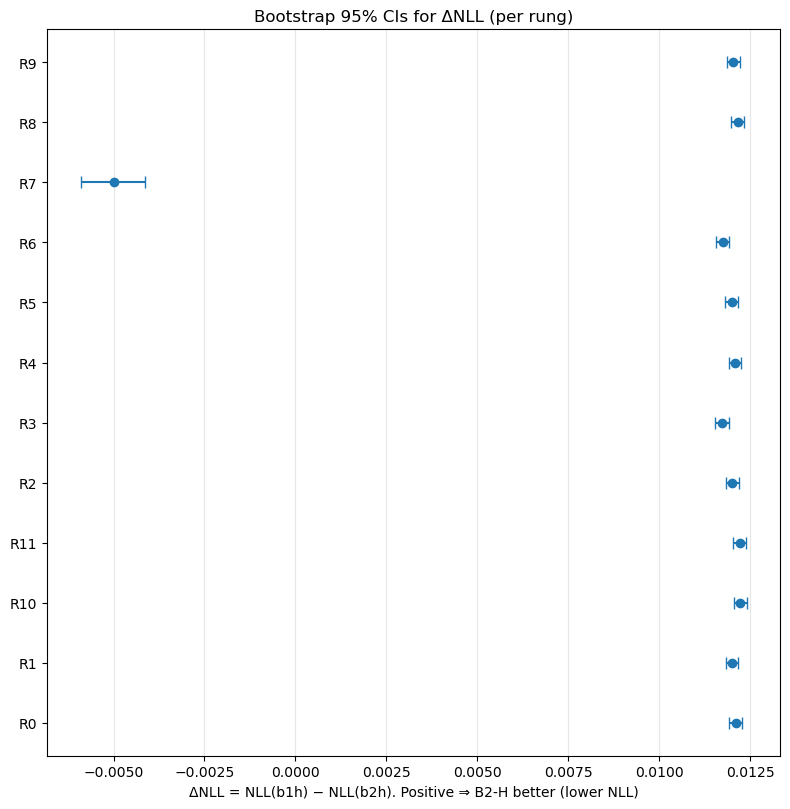

In [9]:
# ΔNLL forest plot (B1-H − B2-H). Positive ⇒ B2-H better.
if len(b1_vs_b2_df):
    xs  = b1_vs_b2_df["delta_nll_mean"].to_numpy()
    xlo = xs - b1_vs_b2_df["delta_nll_ci95_lo"].to_numpy()
    xhi = b1_vs_b2_df["delta_nll_ci95_hi"].to_numpy() - xs
    y   = np.arange(len(b1_vs_b2_df))

    plt.figure(figsize=(8, max(3, 0.6*len(y)+1)))
    plt.errorbar(xs, y, xerr=[xlo, xhi], fmt='o', capsize=4)
    #plt.axvline(0, linestyle='--')
    plt.yticks(y, b1_vs_b2_df["rung"].values)
    plt.xlabel("ΔNLL = NLL(b1h) − NLL(b2h). Positive ⇒ B2-H better (lower NLL)")
    plt.title("Bootstrap 95% CIs for ΔNLL (per rung)")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if WRITE_CSV:
        plt.savefig(OUT_DIR / "forest_delta_nll_b1_vs_b2.png", dpi=300)
    plt.show()
else:
    print("No b1h vs b2h results to plot.")


In [10]:
xlo

array([0.00017748, 0.00017652, 0.00018063, 0.0001797 , 0.0001803 ,
       0.00019293, 0.00017805, 0.00018034, 0.00018088, 0.00092472,
       0.00017863, 0.00018217])


### Forest plot: ΔTop‑1 (B1‑H − B2‑H)
If the CI is entirely **above 0**, B1‑H significantly has higher accuracy.


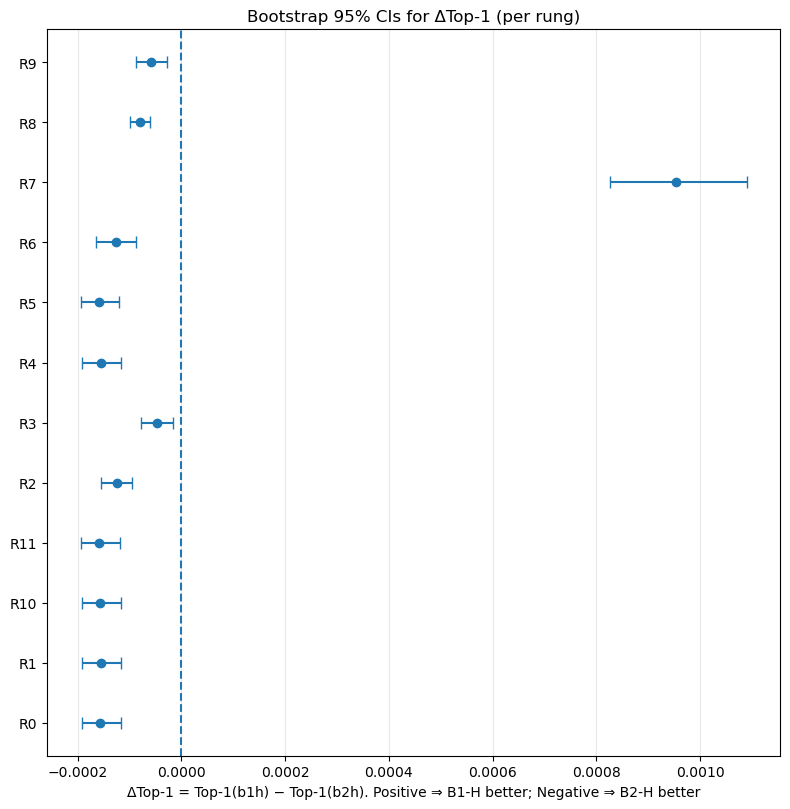

In [11]:
# ΔTop-1 forest plot (B1-H − B2-H). Positive ⇒ B1-H better; Negative ⇒ B2-H better.
if len(b1_vs_b2_df):
    xs  = b1_vs_b2_df["delta_top1_mean"].to_numpy()
    xlo = xs - b1_vs_b2_df["delta_top1_ci95_lo"].to_numpy()
    xhi = b1_vs_b2_df["delta_top1_ci95_hi"].to_numpy() - xs
    y   = np.arange(len(b1_vs_b2_df))

    plt.figure(figsize=(8, max(3, 0.6*len(y)+1)))
    plt.errorbar(xs, y, xerr=[xlo, xhi], fmt='o', capsize=4)
    plt.axvline(0, linestyle='--')
    plt.yticks(y, b1_vs_b2_df["rung"].values)
    plt.xlabel("ΔTop-1 = Top-1(b1h) − Top-1(b2h). Positive ⇒ B1-H better; Negative ⇒ B2-H better")
    plt.title("Bootstrap 95% CIs for ΔTop-1 (per rung)")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if WRITE_CSV:
        plt.savefig(OUT_DIR / "forest_delta_top1_b1_vs_b2.png", dpi=300)
    plt.show()
else:
    print("No b1h vs b2h results to plot.")



### Forest plot: ΔNLL for covariate additions
Here ΔNLL = **Base − Candidate**. Negative CI ⇒ the **candidate (with extra covariate)** is significantly better.



## How to report the results (paper‑ready wording)

- **Metric**: Population‑weighted **Negative Log‑Likelihood (NLL)** on test respondents. Lower is better.  
- **Estimator**: We report **bootstrap means** and **95% percentile CIs** for **ΔNLL = A − B**, where **A = baseline** and **B = candidate**.  
- **Decision rule**: If the 95% CI for ΔNLL excludes zero and is **negative**, the candidate is **significantly better** (lower NLL).  
- **Accuracy**: We also report ΔTop‑1 = Top1(A) − Top1(B) with 95% CIs for completeness (significance if CI excludes 0).

**Suggested text.**  
“Using respondent‑paired PPS bootstrap (B=2000) on the fixed test split, we compared B1‑H and B2‑H for rungs R1–R6.  
A negative ΔNLL (B1‑H − B2‑H) indicates that the hazard model improves fit. We observe that [list rungs where CI < 0] show statistically significant gains, with relative improvements of [x%–y%].  
Separately, adding covariates (e.g., region→region+sex) was evaluated via ΔNLL = Base − Candidate; negative CIs demonstrate benefit from the additional feature.”


In [12]:

bundle = {
    "summary_means_csv": str((OUT_DIR / "summary_mean_metrics.csv").resolve()),
    "b1_vs_b2_csv": str((OUT_DIR / "b1h_vs_b2h_bootstrap_R1_R6.csv").resolve()) if len(globals().get("b1_vs_b2_df", pd.DataFrame())) else None,
    "covariates_csv": str((OUT_DIR / f"covariate_comparisons_{globals().get('COV_VARIANT','b1h')}.csv").resolve()) if len(globals().get("cov_df", pd.DataFrame())) else None
}
with open(OUT_DIR / "paths_manifest.json", "w", encoding="utf-8") as f:
    json.dump(bundle, f, indent=2)
print(json.dumps(bundle, indent=2))


{
  "summary_means_csv": "/ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/summary_mean_metrics.csv",
  "b1_vs_b2_csv": "/ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/b1h_vs_b2h_bootstrap_R1_R6.csv",
  "covariates_csv": null
}
